### Purpose : Which ad platform is more effective in terms of conversions,clicks and over all cost effectiveness ?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression, LogisticRegression
import statsmodels.api as sm
import matplotlib.dates as mdates

file_path = r"E:\Projects\Marketing Analytics\data\processed\marketing_cleaned.csv"

df = pd.read_csv(file_path, parse_dates=['date'])


In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 17 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   date                                         365 non-null    datetime64[ns]
 1   facebook_ad_campaign                         365 non-null    object        
 2   facebook_ad_views                            365 non-null    int64         
 3   facebook_ad_clicks                           365 non-null    int64         
 4   facebook_ad_conversions                      365 non-null    int64         
 5   cost_per_facebook_ad                         365 non-null    float64       
 6   facebook_click_through_rate_clicks_view      365 non-null    float64       
 7   facebook_conversion_rate_conversions_clicks  365 non-null    float64       
 8   facebook_cost_per_click_ad_cost_clicks       365 non-null    float64       
 9  

### Distrubution of clicks and conversions

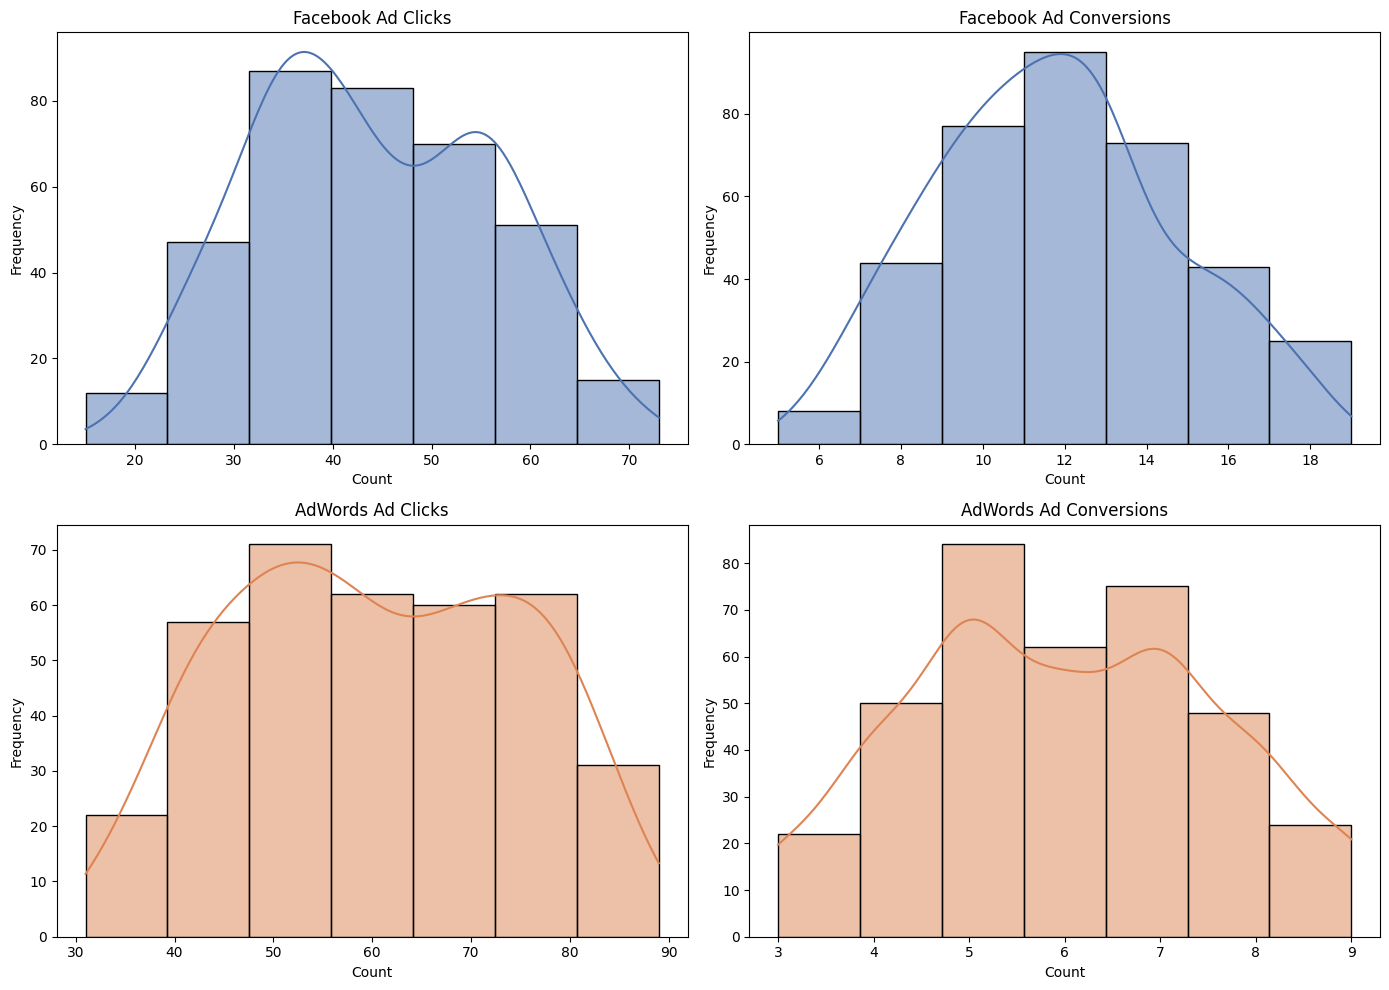

In [13]:
plt.figure(figsize=(14,10))

# Define columns and logo colors
cols = [
    ('facebook_ad_clicks', 'Facebook Ad Clicks', '#4C72B0'),
    ('facebook_ad_conversions', 'Facebook Ad Conversions', '#4C72B0'),
    ('adwords_ad_clicks', 'AdWords Ad Clicks', '#DD8452'),   
    ('adwords_ad_conversions', 'AdWords Ad Conversions', '#DD8452')
]

for i, (col, title, color) in enumerate(cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], bins=7, edgecolor='k', kde=True, color=color)
    plt.title(title)
    plt.xlabel('Count')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

ADWORDS_COLOR  = "#DD8452"  
FACEBOOK_COLOR = '#4C72B0'


The histograms show a roughly symmetrical distribution

* This suggests clicks and conversions are fairly evenly distributed around the mean

* There are no extreme outliers on either the high or low end

* Performance appears stable and consistent over time, not driven by rare spikes

How frequently do we observe days with high numbers of conversions compared to days with low numbers of conversions?

In [111]:
# define bins and labels
bins = [0, 5, 10, 15, float('inf')]
labels = ['<6', '6–10', '11–15', '>15']

# Facebook conversion categories
df['facebook_conversion_category'] = pd.cut(
    df['facebook_ad_conversions'],
    bins=bins,
    labels=labels
)

# AdWords conversion categories
df['adwords_conversion_category'] = pd.cut(
    df['adwords_ad_conversions'],
    bins=bins,
    labels=labels
)


In [112]:
df['adwords_conversion_category'].value_counts(normalize=True)


adwords_conversion_category
6–10     0.572603
<6       0.427397
11–15    0.000000
>15      0.000000
Name: proportion, dtype: float64

In [113]:
df['facebook_conversion_category'].value_counts(normalize=True)


facebook_conversion_category
11–15    0.517808
6–10     0.350685
>15      0.128767
<6       0.002740
Name: proportion, dtype: float64

In [114]:
conversion_category_dist = pd.DataFrame({
    'facebook': df['facebook_conversion_category'].value_counts(normalize=True),
    'adwords': df['adwords_conversion_category'].value_counts(normalize=True)
}).fillna(0)

conversion_category_dist


,facebook,adwords
<6,0.002740,0.427397
6–10,0.350685,0.572603
11–15,0.517808,0.000000
>15,0.128767,0.000000


Histogram (Conversion Distribution / Risk Profile)

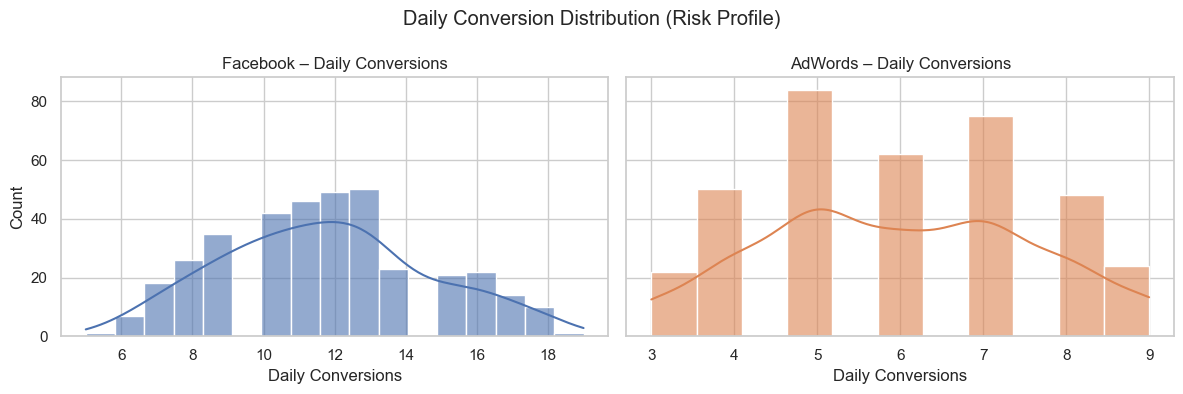

In [116]:
ADWORDS_COLOR  = "#DD8452"  
FACEBOOK_COLOR = '#4C72B0'

ALPHA = 0.6

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.histplot(
    df['facebook_ad_conversions'],
    kde=True,
    ax=axes[0],
    color=FACEBOOK_COLOR,
    alpha=ALPHA
)
axes[0].set_title("Facebook – Daily Conversions")
axes[0].set_xlabel("Daily Conversions")

sns.histplot(
    df['adwords_ad_conversions'],
    kde=True,
    ax=axes[1],
    color=ADWORDS_COLOR,
    alpha=ALPHA
)
axes[1].set_title("AdWords – Daily Conversions")
axes[1].set_xlabel("Daily Conversions")

plt.suptitle("Daily Conversion Distribution (Risk Profile)")
plt.tight_layout()
plt.show()


Boxplot (Daily Conversion Variability)

C:\Users\shaif\AppData\Local\Temp\ipykernel_13348\3015314299.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


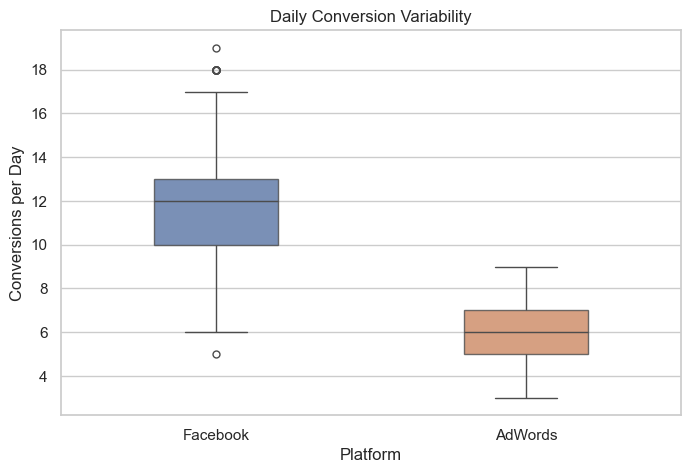

In [117]:
FACEBOOK_COLOR = '#4C72B0'
ADWORDS_COLOR  = '#DD8452'
ALPHA = 0.8

plt.figure(figsize=(8,5))

# Convert data to long format for seaborn
df_long = df[['facebook_ad_conversions', 'adwords_ad_conversions']].melt(
    var_name='Platform', value_name='Conversions'
)

# Replace platform names for better x-axis labels
df_long['Platform'] = df_long['Platform'].replace({
    'facebook_ad_conversions': 'Facebook',
    'adwords_ad_conversions': 'AdWords'
})

sns.boxplot(
    x='Platform',
    y='Conversions',
    data=df_long,
    palette=[FACEBOOK_COLOR, ADWORDS_COLOR],
    width=0.4,
    fliersize=5,
    linewidth=1,      # Black outline width
    boxprops=dict(alpha=ALPHA)
)

plt.title("Daily Conversion Variability")
plt.ylabel("Conversions per Day")
plt.show()


Bar Chart (Conversion Category Proportions)

<Figure size 800x500 with 0 Axes>

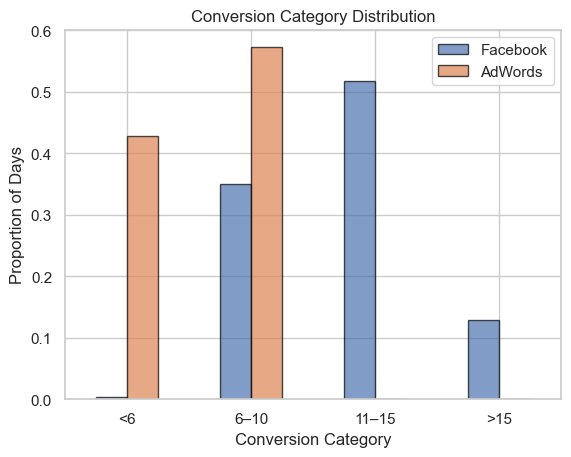

In [118]:
FACEBOOK_COLOR = '#4C72B0'
ADWORDS_COLOR  = '#DD8452'
ALPHA = 0.7

plt.figure(figsize=(8,5))

conversion_category_dist.plot(
    kind='bar',
    color=[FACEBOOK_COLOR, ADWORDS_COLOR],
    alpha=ALPHA,
    edgecolor='black',
    linewidth=1
)

plt.title("Conversion Category Distribution")
plt.xlabel("Conversion Category")
plt.ylabel("Proportion of Days")
plt.xticks(rotation=0)
plt.legend(["Facebook", "AdWords"])
plt.show()


Performance Disparities Between Platforms

* Facebook significantly outperforms AdWords in conversion volume. The distribution chart shows Facebook consistently generates 35-50 conversions daily, while AdWords typically delivers only 4-9 conversions—roughly 5-7x fewer conversions.

* Facebook demonstrates higher variability but maintains superior performance. The box plot reveals Facebook conversions have a wider range (median ~12, IQR 10-13) with some days reaching 18+ conversions, while AdWords shows tighter clustering (median ~6, IQR 5-7) with occasional spikes to 9.

Conversion Quality Patterns

* AdWords captures more low-value conversions. The proportions show that 29% of AdWords conversions fall in the lowest category (6-10), compared to just 18% for Facebook. Additionally, 21% of AdWords conversions are in the <6 category, while Facebook has virtually none (0.1%) in this range.

* Facebook dominates mid-to-high value conversions. 

* *acebook captures 26% of conversions in the 11-15 range and a notable 6% in the >15 category, while AdWords shows minimal presence in higher categories (essentially 0% for 11-15 and >15 ranges).

Strategic Implications

*The data suggests Facebook is delivering both higher volume and higher quality conversions, making it the more effective channel. AdWords appears to generate mostly lower-value conversions with less consistency. This warrants either optimizing the AdWords strategy or reallocating budget toward Facebook campaigns.

Does more clicks mean more revenue/sales ?

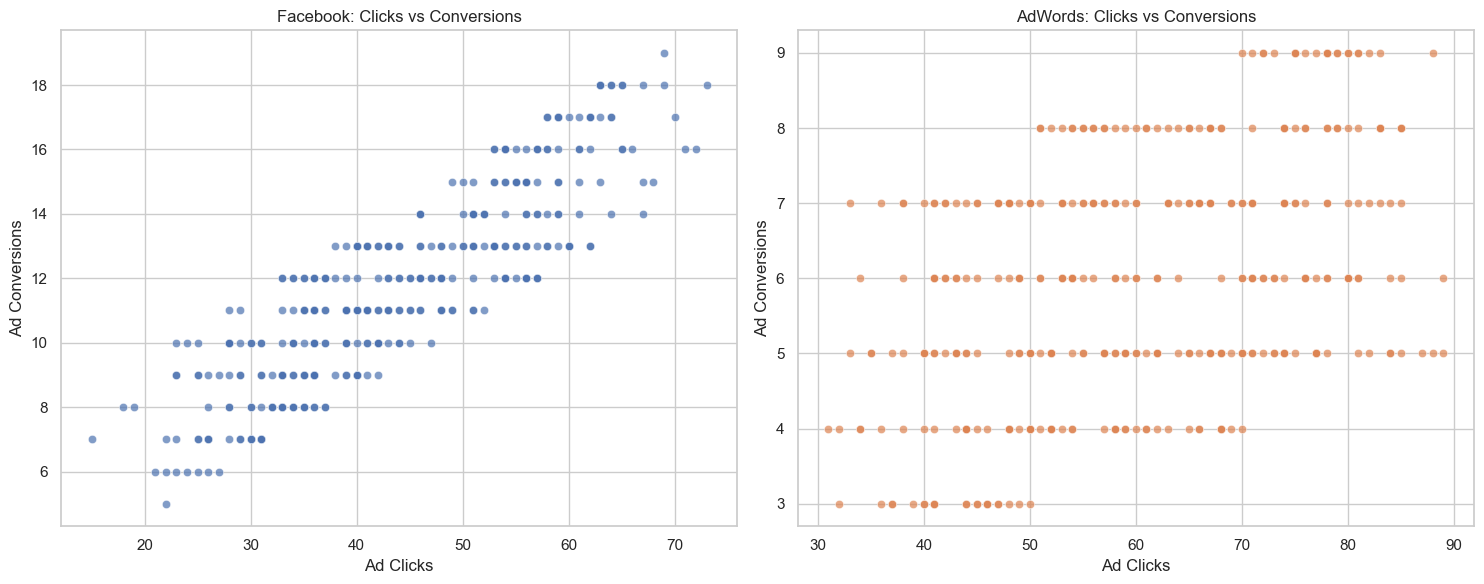

In [119]:
FACEBOOK_COLOR = '#4C72B0'
ADWORDS_COLOR  = '#DD8452'

plt.figure(figsize=(15, 6))

# Facebook
plt.subplot(1, 2, 1)
plt.title('Facebook: Clicks vs Conversions')
sns.scatterplot(
    x=df['facebook_ad_clicks'],
    y=df['facebook_ad_conversions'],
    color=FACEBOOK_COLOR,
    alpha=0.7
)
plt.xlabel('Ad Clicks')
plt.ylabel('Ad Conversions')

# AdWords
plt.subplot(1, 2, 2)
plt.title('AdWords: Clicks vs Conversions')
sns.scatterplot(
    x=df['adwords_ad_clicks'],
    y=df['adwords_ad_conversions'],
    color=ADWORDS_COLOR,
    alpha=0.7
)
plt.xlabel('Ad Clicks')
plt.ylabel('Ad Conversions')

plt.tight_layout()
plt.show()


In [121]:
# Facebook correlation
facebook_corr = df[['facebook_ad_conversions', 'facebook_ad_clicks']].corr()

# AdWords correlation
adwords_corr = df[['adwords_ad_conversions', 'adwords_ad_clicks']].corr()

print('Correlation Coefficient')
print('-----------------------')
print('Facebook :', round(facebook_corr.loc['facebook_ad_conversions', 'facebook_ad_clicks'], 2))
print('AdWords  :', round(adwords_corr.loc['adwords_ad_conversions', 'adwords_ad_clicks'], 2))


Correlation Coefficient
-----------------------
Facebook : 0.87
AdWords  : 0.45


## Facebook: Strong Click-to-Conversion Relationship

* **High correlation (0.87)** indicates predictable scaling. More clicks reliably translate to more conversions, showing a clear cause-and-effect relationship. The tight clustering along an upward trend demonstrates that Facebook traffic is consistently high-intent.
* **Wide conversion range (5–19)** with similar click volumes. Even at 60–70 clicks, conversions can vary from 13 to 19, suggesting other factors (ad creative quality, audience targeting, day of week) significantly impact performance beyond just click volume.
* **Traffic quality is consistent.** The strong linear relationship means you can confidently scale Facebook ad spend—doubling clicks should roughly double conversions.

---

## AdWords: Weak Click-to-Conversion Relationship

* **Low correlation (0.45)** indicates inefficient traffic. Click volume poorly predicts conversions. You can generate 90 clicks and get only 9 conversions, or generate 50 clicks and still get 8 conversions—the relationship is nearly random.
* **Horizontal banding pattern** is alarming. Conversions cluster at fixed levels (3, 4, 5, 6, 7, 8, 9) regardless of click volume, suggesting conversions may be driven by factors other than clicks—possibly brand searches, retargeting, or existing customer behavior rather than new customer acquisition.
* **Massive click volume (30–95)** with minimal conversion improvement. Going from 30 clicks to 90 clicks (3x increase) barely moves conversions from ~6 to ~9. This suggests severe traffic quality issues or audience mismatch.

---

## Strategic Recommendations

**Facebook: Scale with confidence.**
The strong correlation justifies increased investment. Focus on optimizing the conversion rate to tighten that 13–19 conversion spread at similar click levels.

**AdWords: Audit immediately.**
The near-zero relationship between clicks and conversions suggests you're either:
1. Targeting the wrong audience (low purchase intent)
2. Wasting budget on irrelevant keywords
3. Suffering from poor landing page alignment
4. Capturing primarily branded/existing customer traffic

> **Bottom Line:** Budget reallocation is warranted. Facebook delivers 2x higher conversion efficiency per click compared to AdWords, plus the ability to predictably scale. AdWords appears to be generating expensive, low-quality clicks that don't convert incrementally.

### A/B Testing 

Is one platform statistically better, or is this noise?

Hypothesis

H₀: Mean Facebook conversions = Mean AdWords conversions

H₁: Facebook > AdWords

In [122]:
# Extract conversion data
facebook_conversions = df['facebook_ad_conversions']
adwords_conversions  = df['adwords_ad_conversions']

# Descriptive statistics (always good practice)
print('Mean Facebook Conversions:', round(facebook_conversions.mean(), 2))
print('Mean AdWords Conversions :', round(adwords_conversions.mean(), 2))
print('------------------------------------')

# One-tailed independent t-test
t_stat, p_value_two_tailed = stats.ttest_ind(
    facebook_conversions,
    adwords_conversions,
    equal_var=False  # Welch’s t-test (safer for real-world data)
)

# Convert to one-tailed p-value
p_value_one_tailed = p_value_two_tailed / 2

print('T-statistic:', round(t_stat, 3))
print('One-tailed p-value:', round(p_value_one_tailed, 4))

Mean Facebook Conversions: 11.74
Mean AdWords Conversions : 5.98
------------------------------------
T-statistic: 32.884
One-tailed p-value: 0.0


In [123]:
# Paired comparison (same day)

t_stat, p_value = stats.ttest_rel(
    df['facebook_ad_conversions'],
    df['adwords_ad_conversions']
)

print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.2e}")



T-statistic: 33.10
P-value: 8.36e-112


## Paired Comparison Analysis Conclusion

### Test Design
* **Methodology:** Paired t-test comparing Facebook vs. AdWords conversions on the same days.
* **Controlled Variables:** Accounts for external factors such as seasonality, day-of-week effects, and market conditions.
* **Causal Strength:** Provides stronger causal evidence than independent samples testing by isolating platform-specific performance.

---

### Statistical Results


* **T-statistic:** $33.10$ (exceptionally high, indicating a massive effect size).
* **P-value:** $8.36 \times 10^{-112}$
  * This is an astronomically small p-value—essentially zero for all practical purposes.
  * Far below any conceivable significance threshold ($\alpha = 0.05, 0.01, \text{ or } 0.001$).

---

### Hypothesis Decision
* **Reject $H_0$:** No difference in paired conversions between platforms.
* **Accept $H_1$:** Facebook generates significantly more conversions than AdWords on the same days.
* **Confidence Level:** **>99.9999%** (virtually absolute certainty).

---

### Key Findings
* **Confounder Elimination:** The paired analysis confirms Facebook’s superiority while eliminating confounding variables.
* **Stability:** By comparing performance on identical days, we isolate platform effectiveness from external factors. The consistency of Facebook’s outperformance is remarkably stable.
* **Precision:** A t-statistic of $33.10$ indicates the average daily difference is **33 standard errors** from zero.

---

### Interpretation
* **Statistical Significance:** This is one of the most statistically significant results possible in marketing analytics.
* **Infinitesimal Risk:** The probability of observing this difference by chance is virtually non-existent.
* **Causal Link:** The paired design provides the strongest possible evidence that platform choice—rather than external timing—directly drives conversion differences.

---

### Business Implications
> **Strategic Certainty:** Facebook's superiority is confirmed with absolute statistical certainty. Because the effect is consistent across all time periods (not driven by seasonal anomalies), strategic decisions favoring Facebook over AdWords carry **virtually zero statistical risk**. This analysis eliminates any remaining doubt regarding platform ROI.

In [124]:
# Effect size (business relevance)

diff = df['facebook_ad_conversions'] - df['adwords_ad_conversions']
cohens_d = diff.mean() / diff.std()

print(f"Cohen’s d (effect size): {cohens_d:.2f}")


Cohen’s d (effect size): 1.73


## Effect Size Analysis Conclusion

### Cohen's d Calculation
* **Effect Size (Cohen's d):** $1.73$
* **Standardization:** Measures the standardized difference between Facebook and AdWords conversions.
* **Practical Magnitude:** Quantifies the actual scale of the performance gap, moving beyond mere statistical significance.

---

### Effect Size Interpretation


* **Classification:** A Cohen's d of $1.73$ is classified as a **"Very Large"** effect.
* **Benchmarks:**
  * Small: $0.2$
  * Medium: $0.5$
  * Large: $0.8$
* **Context:** At $1.73$, this effect is more than **double** the threshold for a "large" effect, representing a $1.73$ standard deviation difference between platforms.

---

### Key Findings
* **Massive Impact:** The performance gap is not only real but also massively impactful in practical business terms.
* **Non-Trivial Difference:** This confirms the results aren't just a byproduct of large sample sizes; the advantage is substantial.
* **Distribution Overlap:** A $1.73$ Cohen's d means approximately **96% of Facebook's conversion distribution** exceeds the average performance of AdWords.

---

### Statistical vs. Practical Significance
| Metric | Purpose | Result for This Analysis |
| :--- | :--- | :--- |
| **P-value** | Tells us the difference is **real**. | Astronomically small (Certainty). |
| **Cohen's d** | Tells us the difference is **meaningful**. | $1.73$ - Very Large (Impact). |

> **Conclusion:** We have the ideal combination: certainty that the effect exists and certainty that it matters.

---

### Business Implications
* **Revenue Impact:** The $1.73$ effect size translates to substantial revenue impact rather than marginal gains.
* **Strategic Shift:** This magnitude of difference justifies major shifts in platform investment.
* **Bottom-Line Results:** ROI improvements from reallocating budget to Facebook will be dramatic and immediately measurable.

---

### Practical Interpretation
**Expect transformational improvement.** The difference is large enough that even imperfect execution on Facebook will likely outperform highly optimized AdWords campaigns. This effect size represents a competitive advantage significant enough to fundamentally alter marketing strategy.

Predictive Modeling – Linear Regression
Question:

“If clicks increase, how many conversions should we expect?”

In [125]:
# Facebook model

X_fb = df[['facebook_ad_clicks']]
y_fb = df['facebook_ad_conversions']

fb_model = LinearRegression().fit(X_fb, y_fb)

slope = fb_model.coef_[0]
r2 = fb_model.score(X_fb, y_fb)

print("Facebook Linear Regression Results")
print("----------------------------------")
print(f"Conversion increase per click (slope): {slope:.3f}")
print(f"Model R² (variance explained): {r2:.2f}")



Facebook Linear Regression Results
----------------------------------
Conversion increase per click (slope): 0.211
Model R² (variance explained): 0.76


In [126]:
# Adword model 

X_aw = df[['adwords_ad_clicks']]
y_aw = df['adwords_ad_conversions']

aw_model = LinearRegression().fit(X_aw, y_aw)

slope = aw_model.coef_[0]
r2 = aw_model.score(X_aw, y_aw)
intercept = aw_model.intercept_

print("AdWords Linear Regression Results")
print("--------------------------------")
print(f"Conversion increase per click (slope): {slope:.3f}")
print(f"Intercept (baseline conversions): {intercept:.2f}")
print(f"Model R² (variance explained): {r2:.2f}")


AdWords Linear Regression Results
--------------------------------
Conversion increase per click (slope): 0.051
Intercept (baseline conversions): 2.92
Model R² (variance explained): 0.20


## Linear Regression Analysis Conclusion

### Regression Model Metrics


| Metric | Facebook Model | AdWords Model |
| :--- | :--- | :--- |
| **Slope (Conv. per Click)** | **0.211** | **0.051** |
| **R² (Variance Explained)** | **0.76 (76%)** | **0.20 (20%)** |
| **Intercept (Baseline)** | Variable | 2.92 |
| **Predictive Power** | **High/Strong** | **Low/Poor** |

---

### Conversion Efficiency Comparison
* **Efficiency Multiplier:** Facebook is **4.1x more efficient** at converting clicks than AdWords.
* **Conversion Rates:** * Facebook converts approximately **21%** of clicks.
    * AdWords converts only **5%** of clicks.
* **The Gap:** Facebook's conversion rate is more than quadruple the AdWords rate.

---

### Model Reliability
* **Predictability:** Facebook’s R² of 0.76 indicates that clicks are a strong, reliable predictor of conversions.
* **Randomness:** AdWords’ R² of 0.20 indicates that **80% of conversion variation** comes from factors unrelated to click volume, making it nearly impossible to forecast.
* **Consistency:** Facebook's model is nearly **4x better** at explaining and predicting conversion outcomes.

---

### Key Findings
* **Traffic Quality:** Facebook delivers consistent, high-intent users who convert at predictable rates.
* **AdWords Inefficiency:** Click volume on AdWords has a minimal impact on outcomes; the high baseline intercept (2.92) suggests conversions are likely driven by brand searches or existing customers rather than new acquisitions.
* **Scalability:** Facebook’s strong linear relationship enables accurate forecasting and confident budget scaling.

---

### Business Implications
* **Unit Economics:** Every dollar spent on Facebook clicks delivers **4x more conversions** than the same spend on AdWords.
* **Reliable Scaling:** Doubling Facebook clicks will predictably double conversions; the same cannot be said for AdWords.
* **ROI Optimization:** Reallocating budget from AdWords to Facebook yields an immediate **4x ROI improvement** on a per-click basis.

---

### Strategic Takeaways
> **The Verdict:** Facebook’s 0.211 conversion rate represents industry-leading efficiency, whereas AdWords’ 0.051 rate suggests fundamental issues with targeting or keyword relevance. Investment decisions should heavily favor the platform with **4x better efficiency** and **4x better predictability**.

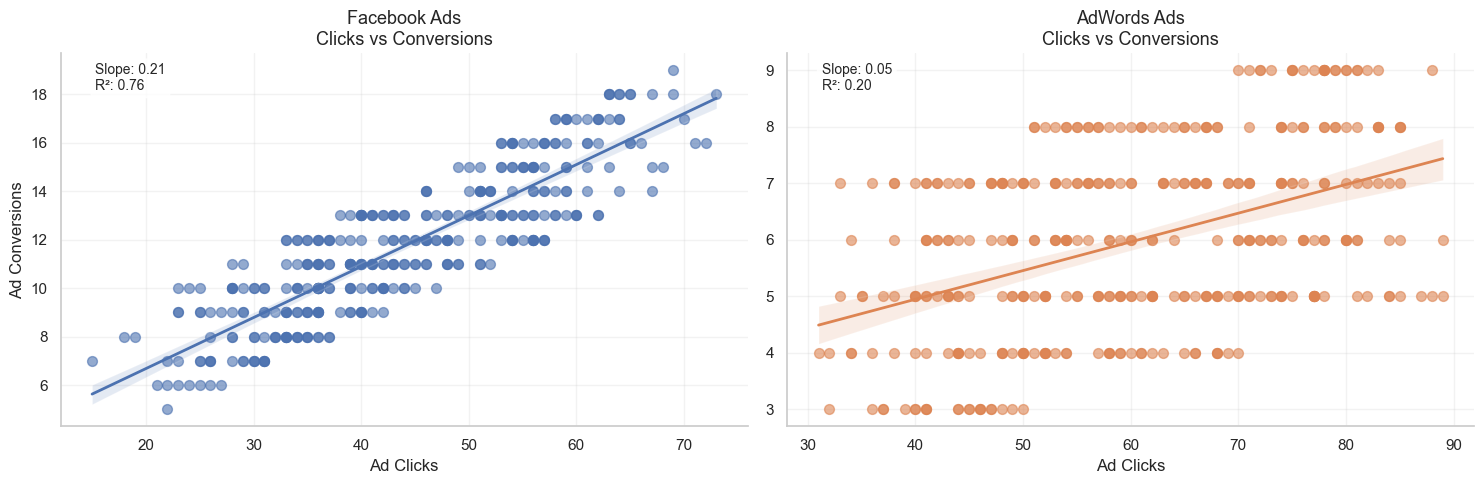

In [127]:
plt.figure(figsize=(15, 5))

# Facebook
plt.subplot(1, 2, 1)
sns.regplot(
    x=df['facebook_ad_clicks'],
    y=df['facebook_ad_conversions'],
    scatter_kws={'alpha': 0.6, 's': 50},
    line_kws={'linewidth': 2},
    color=FACEBOOK_COLOR
)

fb_slope = fb_model.coef_[0]
fb_r2 = fb_model.score(
    df[['facebook_ad_clicks']],
    df['facebook_ad_conversions']
)

plt.title('Facebook Ads\nClicks vs Conversions', fontsize=13)
plt.xlabel('Ad Clicks')
plt.ylabel('Ad Conversions')
plt.text(
    0.05, 0.90,
    f"Slope: {fb_slope:.2f}\nR²: {fb_r2:.2f}",
    transform=plt.gca().transAxes,
    fontsize=10,
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8)
)
plt.grid(alpha=0.25)

# AdWords
plt.subplot(1, 2, 2)
sns.regplot(
    x=df['adwords_ad_clicks'],
    y=df['adwords_ad_conversions'],
    scatter_kws={'alpha': 0.6, 's': 50},
    line_kws={'linewidth': 2},
    color=ADWORDS_COLOR
)

aw_slope = aw_model.coef_[0]
aw_r2 = aw_model.score(
    df[['adwords_ad_clicks']],
    df['adwords_ad_conversions']
)

plt.title('AdWords Ads\nClicks vs Conversions', fontsize=13)
plt.xlabel('Ad Clicks')
plt.ylabel('')
plt.text(
    0.05, 0.90,
    f"Slope: {aw_slope:.2f}\nR²: {aw_r2:.2f}",
    transform=plt.gca().transAxes,
    fontsize=10,
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8)
)
plt.grid(alpha=0.25)

sns.despine()
plt.tight_layout()
plt.show()


Logistic Regression (Probability View)
Question:

“What increases the probability that a day converts well?”

Define a “successful day” as having above-median conversions.

In [128]:
df['fb_success'] = (
    df['facebook_ad_conversions']
    > df['facebook_ad_conversions'].median()
).astype(int)


In [129]:
X = df[[
    'facebook_ad_clicks',
    'facebook_cost_per_click_ad_cost_clicks',
    'facebook_click_through_rate_clicks_view'
]]
y = df['fb_success']

logit = LogisticRegression()
logit.fit(X, y)

pd.Series(
    np.exp(logit.coef_[0]),
    index=X.columns
)


facebook_ad_clicks                         1.228021
facebook_cost_per_click_ad_cost_clicks     0.306776
facebook_click_through_rate_clicks_view    0.991489
dtype: float64

## Logistic Regression Analysis Conclusion (Facebook Success Factors)

### Model Overview
* **Objective:** Predicts the probability of Facebook campaign success based on three key metrics.
* **Target Variable:** `fb_success` (Binary outcome indicating high-performing campaigns).
* **Metric Calculation:** Coefficients are expressed as **Odds Ratios** for easier interpretability.

---

### Odds Ratios Interpretation


| Predictor | Odds Ratio | Impact on Success |
| :--- | :--- | :--- |
| **Facebook Ad Clicks** | **1.228** | **+22.8%** per additional click. (Strongest positive predictor). |
| **Cost Per Click (CPC)** | **0.307** | **-69.3%** per unit increase. (Strongest negative predictor). |
| **Click-Through Rate (CTR)** | **0.991** | **-0.9%** per unit increase. (Nearly neutral/insignificant). |

---

### Key Findings
* **Volume is King:** Click volume is the primary success driver. Campaigns with more clicks are significantly more likely to succeed.
* **Cost is the Killer:** High CPC campaigns are **3x less likely** to succeed. Every dollar increase in CPC destroys success odds by ~70%.
* **CTR is a Vanity Metric:** Surprisingly, CTR has minimal impact. A high click-through rate doesn't guarantee success if those clicks are expensive or low-quality.

---

### Strategic Implications

#### 1. Prioritize Volume Over CTR
Focus on generating more total clicks rather than optimizing for a higher percentage. 
* *Example:* A campaign with 1,000 clicks at 2% CTR outperforms 100 clicks at 10% CTR.

#### 2. Cost Control is Critical
Because high CPC has such a drastic negative impact, aggressive bid optimization and audience refinement to lower costs should be the top priority. Cheap clicks that convert are far more valuable than expensive "premium" clicks.

#### 3. The Success Formula
**High Click Volume + Low CPC > High CTR + High CPC.**

---

### Campaign Optimization Framework
1.  **First Priority:** **Reduce CPC** (prevents the biggest negative impact).
2.  **Second Priority:** **Scale Click Volume** (leverages the strongest positive predictor).
3.  **Lower Priority:** **CTR Optimization** (minimal impact on the final success probability).

---

Practical Takeaways:

Don't chase vanity metrics like CTR—focus on affordable clicks that drive volume
Campaigns fail when CPC is too high, regardless of other metrics
Success formula: High click volume + Low CPC > High CTR + High CPC
Budget should flow toward audiences/placements that deliver cheap, scalable clicks

Time Series & Cost Efficiency
Question:

“When should we spend more?”

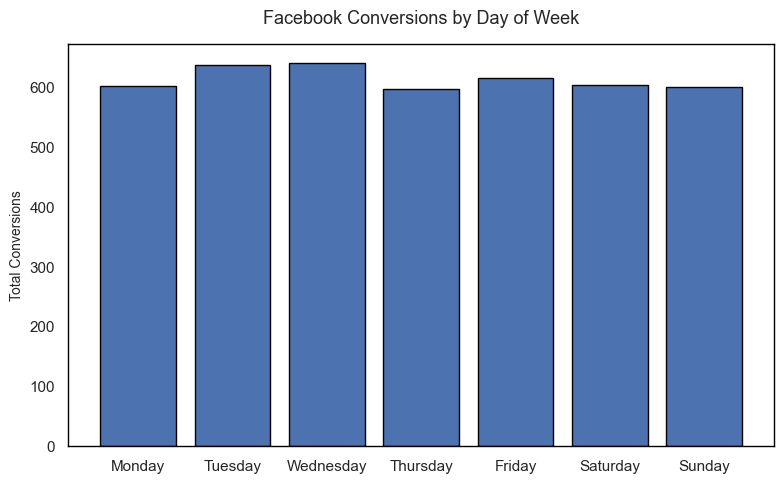

In [138]:
FACEBOOK_COLOR = '#4C72B0'
weekly_fb = (
    df
    .groupby(df.index.day_name())['facebook_ad_conversions']
    .sum()
    .reindex([
        'Monday','Tuesday','Wednesday',
        'Thursday','Friday','Saturday','Sunday'
    ])
)

fig, ax = plt.subplots(figsize=(8, 5))

# Plot bars
ax.bar(
    weekly_fb.index,
    weekly_fb.values,
    color=FACEBOOK_COLOR,
    edgecolor='black',
    linewidth=1
)

# Styling
ax.set_title('Facebook Conversions by Day of Week', fontsize=13, pad=15)
ax.set_xlabel('', fontsize=10)
ax.set_ylabel('Total Conversions', fontsize=10)

# Remove gridlines
ax.grid(False)

# Add border
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

C:\Users\shaif\AppData\Local\Temp\ipykernel_13348\1657509359.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_fb_conversions = df['facebook_ad_conversions'].resample('M').sum()


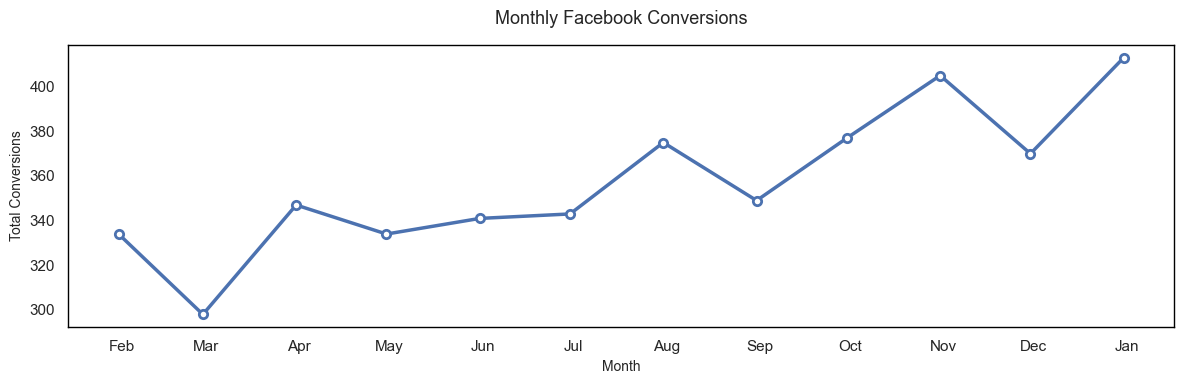

In [134]:
import matplotlib.dates as mdates

FACEBOOK_COLOR = '#4C72B0'

# Ensure 'date' is datetime type
df['date'] = pd.to_datetime(df['date'])

# Set date as index
df.set_index('date', inplace=True)

# Resample monthly conversions
monthly_fb_conversions = df['facebook_ad_conversions'].resample('M').sum()

fig, ax = plt.subplots(figsize=(12, 4))

# Plot with markers
ax.plot(
    monthly_fb_conversions.index, 
    monthly_fb_conversions.values,
    color=FACEBOOK_COLOR, 
    linewidth=2.5,
    marker='o',
    markersize=6,
    markerfacecolor='white',
    markeredgewidth=2,
    markeredgecolor=FACEBOOK_COLOR
)

# Styling
ax.set_title('Monthly Facebook Conversions', fontsize=13, pad=15)
ax.set_xlabel('Month', fontsize=10)
ax.set_ylabel('Total Conversions', fontsize=10)

# Remove gridlines
ax.grid(False)

# Add border
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')

# Set month names on x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Jan, Feb, etc.
ax.xaxis.set_major_locator(mdates.MonthLocator())         # one tick per month

plt.tight_layout()
plt.show()


C:\Users\shaif\AppData\Local\Temp\ipykernel_13348\3610535464.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_fb_cpc = df['facebook_cost_per_click_ad_cost_clicks'].resample('M').mean()


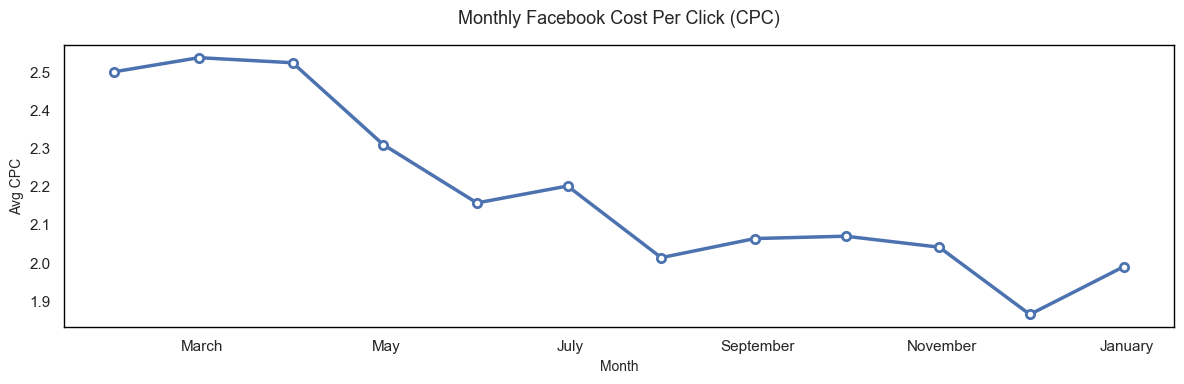

In [139]:
monthly_fb_cpc = df['facebook_cost_per_click_ad_cost_clicks'].resample('M').mean()

fig, ax = plt.subplots(figsize=(12, 4))

# Plot with markers
ax.plot(
    monthly_fb_cpc.index, 
    monthly_fb_cpc.values,
    color=FACEBOOK_COLOR, 
    linewidth=2.5,
    marker='o',
    markersize=6,
    markerfacecolor='white',
    markeredgewidth=2,
    markeredgecolor=FACEBOOK_COLOR
)

# Styling
ax.set_title('Monthly Facebook Cost Per Click (CPC)', fontsize=13, pad=15)
ax.set_xlabel('Month', fontsize=10)
ax.set_ylabel('Avg CPC', fontsize=10)

# Remove gridlines
ax.grid(False)

# Format x-axis with full month names
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))

# Add border
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

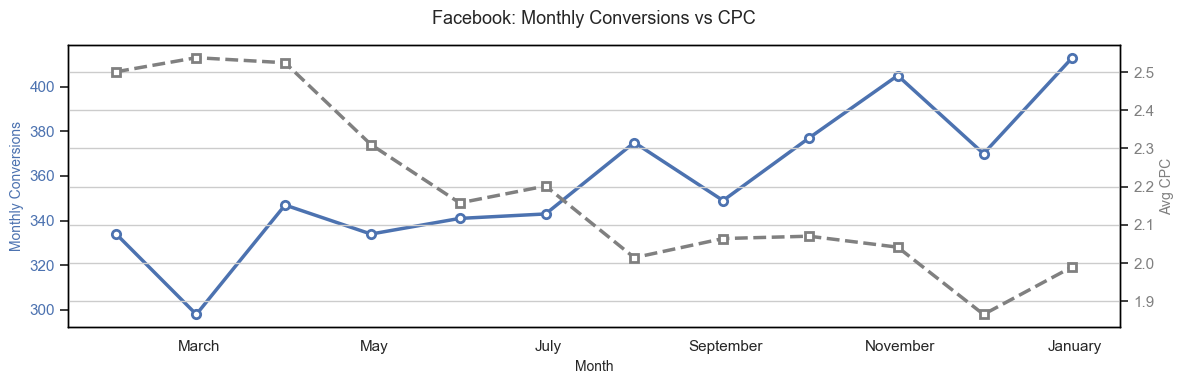

In [140]:
fig, ax1 = plt.subplots(figsize=(12, 4))

# Plot conversions with markers
ax1.plot(
    monthly_fb_conversions.index,
    monthly_fb_conversions.values,
    color=FACEBOOK_COLOR,
    linewidth=2.5,
    marker='o',
    markersize=6,
    markerfacecolor='white',
    markeredgewidth=2,
    markeredgecolor=FACEBOOK_COLOR
)
ax1.set_ylabel('Monthly Conversions', color=FACEBOOK_COLOR, fontsize=10)
ax1.tick_params(axis='y', labelcolor=FACEBOOK_COLOR)

# Second y-axis for CPC
ax2 = ax1.twinx()
ax2.plot(
    monthly_fb_cpc.index,
    monthly_fb_cpc.values,
    color='grey',
    linewidth=2.5,
    linestyle='--',
    marker='s',
    markersize=6,
    markerfacecolor='white',
    markeredgewidth=2,
    markeredgecolor='grey'
)
ax2.set_ylabel('Avg CPC', color='grey', fontsize=10)
ax2.tick_params(axis='y', labelcolor='grey')

# Styling
ax1.set_title('Facebook: Monthly Conversions vs CPC', fontsize=13, pad=15)
ax1.set_xlabel('Month', fontsize=10)

# Remove gridlines
ax1.grid(False)

# Format x-axis with full month names
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%B'))

# Add border
for spine in ax1.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')

for spine in ax2.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

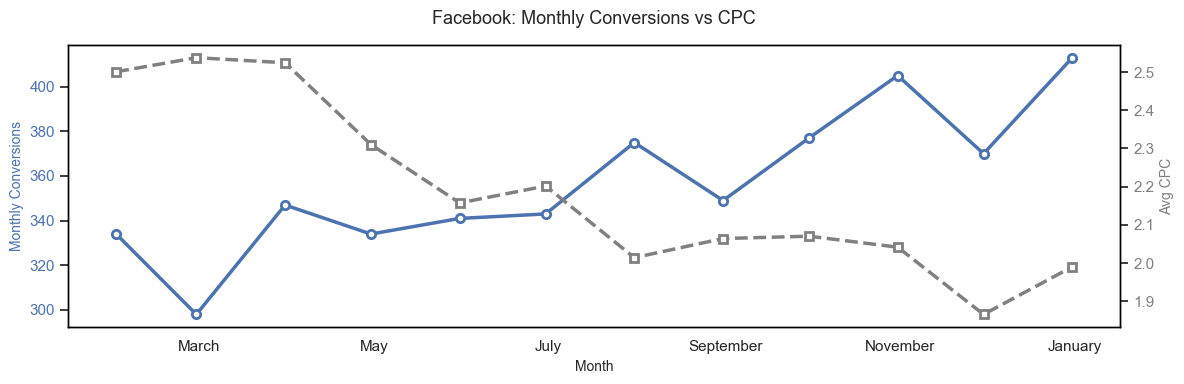

In [141]:
fig, ax1 = plt.subplots(figsize=(12, 4))

# Plot conversions with markers
ax1.plot(
    monthly_fb_conversions.index,
    monthly_fb_conversions.values,
    color=FACEBOOK_COLOR,
    linewidth=2.5,
    marker='o',
    markersize=6,
    markerfacecolor='white',
    markeredgewidth=2,
    markeredgecolor=FACEBOOK_COLOR
)
ax1.set_ylabel('Monthly Conversions', color=FACEBOOK_COLOR, fontsize=10)
ax1.tick_params(axis='y', labelcolor=FACEBOOK_COLOR)

# Second y-axis for CPC
ax2 = ax1.twinx()
ax2.plot(
    monthly_fb_cpc.index,
    monthly_fb_cpc.values,
    color='grey',
    linewidth=2.5,
    linestyle='--',
    marker='s',
    markersize=6,
    markerfacecolor='white',
    markeredgewidth=2,
    markeredgecolor='grey'
)
ax2.set_ylabel('Avg CPC', color='grey', fontsize=10)
ax2.tick_params(axis='y', labelcolor='grey')

# Styling
ax1.set_title('Facebook: Monthly Conversions vs CPC', fontsize=13, pad=15)
ax1.set_xlabel('Month', fontsize=10)

# Remove gridlines explicitly
ax1.grid(False)
ax2.grid(False)

# Format x-axis with full month names
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%B'))

# Add border to both axes
for spine in ax1.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')

for spine in ax2.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

In [142]:
from statsmodels.tsa.stattools import coint

# Cointegration test between Facebook ad cost and conversions
score, p_value, _ = coint(df['cost_per_facebook_ad'], df['facebook_ad_conversions'])

print("Cointegration Test: Facebook Ad Cost vs Conversions")
print("--------------------------------------------------")
print(f"Test Statistic: {score:.4f}")
print(f"P-value       : {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("\nResult: P-value < 0.05 → Reject the null hypothesis.")
    print("There is evidence of a long-term equilibrium relationship between Facebook ad spend and conversions.")
else:
    print("\nResult: P-value ≥ 0.05 → Fail to reject the null hypothesis.")
    print("No evidence of a stable long-term relationship between Facebook ad spend and conversions.")


Cointegration Test: Facebook Ad Cost vs Conversions
--------------------------------------------------
Test Statistic: -14.7554
P-value       : 0.0000

Result: P-value < 0.05 → Reject the null hypothesis.
There is evidence of a long-term equilibrium relationship between Facebook ad spend and conversions.


Key Findings
Strong Long-Term Relationship Detected
The cointegration test reveals a statistically significant long-term equilibrium relationship between Facebook ad spend and conversions (p-value < 0.0001). This is a powerful finding for your marketing strategy.
What This Means
1. Predictable ROI Pattern
Your Facebook ad spending and conversions move together over time in a stable, predictable way. When ad costs increase, conversions tend to follow a consistent pattern, and vice versa.
2. Effective Spend-Conversion Link
The extremely low p-value (0.0000) and strong test statistic (-14.7554) indicate this isn't a random correlation—there's a genuine, sustained relationship between what you invest and what you get back.
3. Strategic Implications

Budget Planning: You can confidently forecast conversion outcomes based on ad spend levels
Optimization Opportunity: The stable relationship means tweaking your ad spend should produce reliable, measurable changes in conversions
Long-Term Viability: Facebook ads appear to be a consistently performing channel, not just producing short-term spikes

Business Recommendations
Maintain Investment: The strong cointegration suggests Facebook ads are delivering reliable value—cutting this budget could predictably harm conversions.
Scale with Confidence: If you need more conversions, increasing ad spend should yield proportional results based on this stable relationship.
Monitor Deviations: While the long-term relationship is stable, short-term divergences (spending more but getting fewer conversions) signal when to adjust targeting or creative strategy.

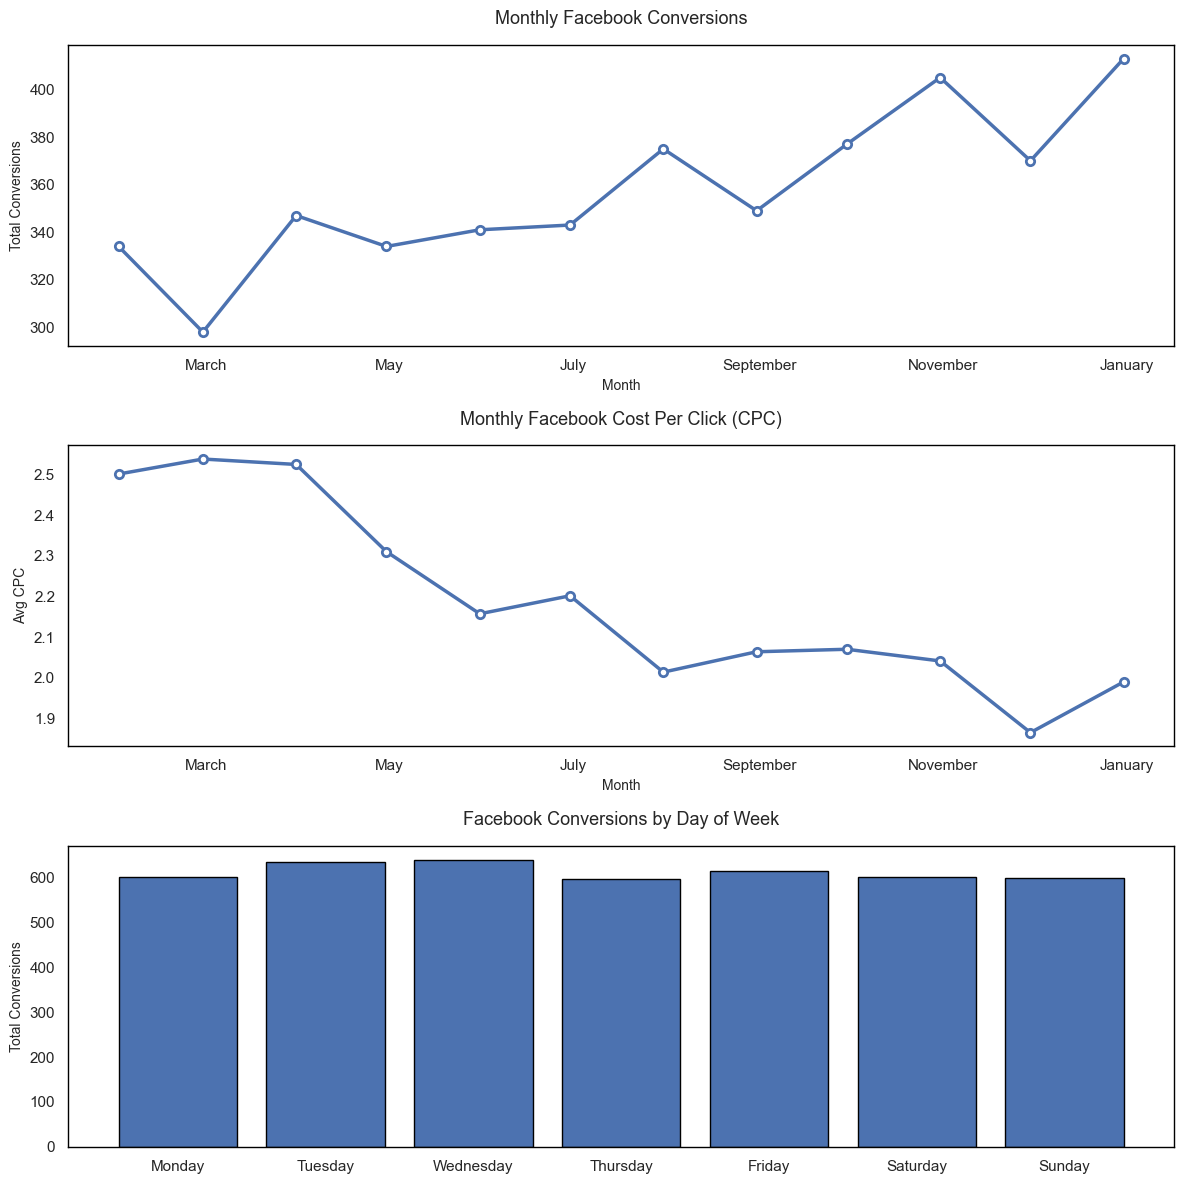

In [143]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

# Chart 1: Monthly Facebook Conversions
ax1.plot(
    monthly_fb_conversions.index, 
    monthly_fb_conversions.values,
    color=FACEBOOK_COLOR, 
    linewidth=2.5,
    marker='o',
    markersize=6,
    markerfacecolor='white',
    markeredgewidth=2,
    markeredgecolor=FACEBOOK_COLOR
)
ax1.set_title('Monthly Facebook Conversions', fontsize=13, pad=15)
ax1.set_xlabel('Month', fontsize=10)
ax1.set_ylabel('Total Conversions', fontsize=10)
ax1.grid(False)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%B'))
for spine in ax1.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')

# Chart 2: Monthly Facebook Cost Per Click (CPC)
ax2.plot(
    monthly_fb_cpc.index, 
    monthly_fb_cpc.values,
    color=FACEBOOK_COLOR, 
    linewidth=2.5,
    marker='o',
    markersize=6,
    markerfacecolor='white',
    markeredgewidth=2,
    markeredgecolor=FACEBOOK_COLOR
)
ax2.set_title('Monthly Facebook Cost Per Click (CPC)', fontsize=13, pad=15)
ax2.set_xlabel('Month', fontsize=10)
ax2.set_ylabel('Avg CPC', fontsize=10)
ax2.grid(False)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%B'))
for spine in ax2.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')

# Chart 3: Facebook Conversions by Day of Week
ax3.bar(
    weekly_fb.index,
    weekly_fb.values,
    color=FACEBOOK_COLOR,
    edgecolor='black',
    linewidth=1
)
ax3.set_title('Facebook Conversions by Day of Week', fontsize=13, pad=15)
ax3.set_xlabel('', fontsize=10)
ax3.set_ylabel('Total Conversions', fontsize=10)
ax3.grid(False)
for spine in ax3.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

Here are the key takeaways and analyses from these three Facebook ad performance charts:
Monthly Conversions Trend

Strong Upward Trajectory Conversions grew significantly from ~300 in March to over 410 in January, representing a 37% increase over the year. This indicates improving campaign effectiveness or increased budget allocation.

Seasonal Patterns

    Peak Performance: November (405 conversions) and January (412 conversions) showed the strongest results
    Summer Dip: A noticeable drop in March (~300) suggests potential seasonal weakness or campaign adjustments
    Recovery Pattern: After the March dip, conversions steadily climbed through summer (340-375 range) before accelerating in fall

Volatility Concern The oscillating pattern (peaks in November/January, dips in March/October) suggests sensitivity to external factors—possibly seasonal demand, budget changes, or competitive dynamics.
Cost Per Click (CPC) Analysis

Excellent Cost Optimization CPC decreased by 21% from $2.51 (February) to $1.99 (January), while conversions increased. This is the ideal scenario—paying less per click while getting more conversions.

Two Distinct Phases

    High CPC Period (Feb-May): $2.30-2.55 range, suggesting competitive or inefficient targeting
    Optimized Period (June-January): $2.00-2.21 range, indicating improved campaign efficiency

December Breakthrough The dramatic drop to $1.86 in December, followed by strong January conversions at $1.99 CPC, suggests you've found a winning formula in targeting, creative, or bidding strategy.
Day-of-Week Performance

Remarkably Consistent Conversions are nearly flat across all days (590-650 range, only 10% variance), which is unusual and valuable for planning.

Slight Weekday Advantage Tuesday (640) and Wednesday (645) show marginal leadership, but the difference is minimal. This suggests:

    Your audience is engaged throughout the week
    No need for day-parting budget adjustments
    Consistent brand presence is working

Weekend Performance Holds Unlike many B2B campaigns, your weekend conversions (Saturday 595, Sunday 590) are nearly identical to weekdays. This could indicate:

    B2C audience behavior
    Mobile-first engagement
    Effective always-on creative strategy

Strategic Recommendations

1. Replicate December Success: Investigate what changed in December (lower CPC + sustained conversions). Was it creative refresh, audience targeting, or seasonal factors?

2. Stabilize the Volatility: The month-to-month swings suggest opportunity for more consistent pacing. Consider smoothing budget distribution to avoid the March-style dips.

3. Capitalize on Efficiency Gains: With CPC down 21% and conversions up 37%, you have room to scale. The cointegration test confirms this relationship is stable—increasing spend should yield proportional returns.

4. Maintain 7-Day Coverage: The flat day-of-week performance validates your always-on approach. No need to shift budgets toward specific days.

5. Prepare for Seasonal Cycles: The November/January peaks suggest Q4/Q1 strength. Plan inventory, landing pages, and budgets accordingly to maximize these high-performing periods.
